### Build and Plot a Regression Tree (from Scratch)
In this implementation, I've created a regression tree from scratch using the logic we covered in the course: 
For each feature, the Residual Sum of Squares (RSS) is calculated at deifferent **thresholds**.

Note: To keep the logic simple I setted the logic to choose the tresholds as follows: 
- For continuous features, thresholds are determined by dividing the range of the feature into evenly spaced intervals, as specified by the num_thresholds parameter.
- For discrete features, all unique values are considered as potential thresholds.

The tree splits the dataset recursively by selecting the feature and threshold combination that yields the **overall smallest RSS**. The splitting continue until a node contains fewer observations than the specified **min_samples_split** parameter. Such nodes are treated as leaves.


In the first part of the code, I defined the logic for calculating the RSS and to find the best split, i.e. find the pair (feature, threshold) having the lowest RSS over all the features. Next, I defined the logic for recursivilly build the tree and also to visualize (plot) the resulting tree.

With this setup, you can easily build and visualize a regression tree for any dataset. To use it, simply provide your dataset in a Pandas DataFrame, specify the target variable and set the min_samples_split and num_thresholds parameters. After that, you can run the two methods to build and plot the tree.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Function to calculate RSS for a split
def calculate_rss(y, right_mask, left_mask):
    right_mean = y[right_mask].mean() if right_mask.any() else 0
    rss_right = ((right_mean - y[right_mask]) ** 2).sum()
    left_mean = y[left_mask].mean() if left_mask.any() else 0
    rss_left = ((left_mean - y[left_mask]) ** 2).sum()
    return rss_left + rss_right

# Function to find the best split
def find_best_split(X, y, num_thresholds=5):
    best_feature, best_threshold, min_rss = None, None, float("inf")
    n_features = X.shape[1]
    
    for feature_idx in range(n_features):
        feature_values = X.iloc[:, feature_idx]
        
        # Check if the feature is discrete (categorical) or continuous
        if feature_values.dtype == "object" or len(feature_values.unique()) <= num_thresholds:
            # if the feature is discrete consider all values as tresholds
            thresholds = feature_values.unique()
        else:
            # if the feature is continuous consider a number of tresholds (equal to the number specified in num_thresholds) that divide its
            # range into evenly spaced intervals
            step = (feature_values.max() - feature_values.min()) / (num_thresholds + 1) # step size (distance between consecutive thresholds)
            thresholds = [feature_values.min() + i * step for i in range(1, num_thresholds + 1)]

        for threshold in thresholds:
            if isinstance(threshold, (int, float)):
                right_mask = feature_values > threshold
                left_mask = feature_values <= threshold
            else:
                right_mask = feature_values != threshold
                left_mask = feature_values == threshold

            rss = calculate_rss(y, right_mask, left_mask)
            if rss < min_rss:
                min_rss = rss
                best_feature = X.columns[feature_idx]
                best_threshold = threshold
    
    return best_feature, best_threshold, min_rss

In [ ]:
# Recursive tree building
def build_regression_tree(X, y, min_samples_split=20, num_thresholds=5):
    # Base case: Stop splitting if there are fewer samples than `min_samples_split`
    if len(y) < min_samples_split or len(np.unique(y)) == 1:
        return {"leaf": True, "value": y.mean()}
    
    # Find the best split
    best_feature, best_threshold, min_rss = find_best_split(X, y, num_thresholds)
    
    # If no valid split is found, return a leaf node
    if best_feature is None:
        return {"leaf": True, "value": y.mean()}
    
    # Perform the split
    if isinstance(best_threshold, (int, float)):
        right_mask = X[best_feature] > best_threshold
        left_mask = X[best_feature] <= best_threshold
    else:
        right_mask = X[best_feature] == best_threshold
        left_mask = X[best_feature] != best_threshold
    
    # Remove the feature used for splitting (to consider only the reamining ones in the next split)
    remaining_features = X.columns.difference([best_feature])
    X_left = X.loc[left_mask, remaining_features]
    X_right = X.loc[right_mask, remaining_features]
    
    # Recursively build left and right subtrees
    right_subtree = build_regression_tree(X_right, y[right_mask], min_samples_split, num_thresholds)
    left_subtree = build_regression_tree(X_left, y[left_mask], min_samples_split, num_thresholds)
    
    # Return the decision node
    return {
        "leaf": False,
        "feature": best_feature,
        "threshold": best_threshold,
        "right": right_subtree,
        "left": left_subtree,
    }

In [ ]:
# Recursive tree-plotting function for a regression tree
def plot_regression_tree(X, tree, pos=(0.5, 1), depth=0, offset=0.2, num_thresholds=5):
    _, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    plot_subtree(X, tree, ax, pos, depth, offset, num_thresholds)
    plt.show()

def plot_subtree(X, tree, ax, pos, depth, offset, num_thresholds):
    if tree["leaf"]:
        ax.text(*pos, f'{tree["value"]:.2f}', bbox=dict(boxstyle='round', facecolor='lightgreen'), ha='center')
    else:
        feature = tree["feature"]
        threshold = tree["threshold"]
        
        if X[feature].dtype == "object" or len(X[feature].unique()) <= num_thresholds:
            operator = "="
        else:
            operator = ">"
        
        ax.text(*pos, f'{feature} {operator} {threshold}', bbox=dict(boxstyle='round', facecolor='lightblue'), ha='center')
        child_offset = offset / (depth + 1)
        left_pos = (pos[0] - child_offset, pos[1] - 0.15)
        right_pos = (pos[0] + child_offset, pos[1] - 0.15)
        ax.plot([pos[0], left_pos[0]], [pos[1], left_pos[1]], color='gray')
        ax.plot([pos[0], right_pos[0]], [pos[1], right_pos[1]], color='gray')
        plot_subtree(X, tree["left"], ax, left_pos, depth + 1, child_offset, num_thresholds)
        plot_subtree(X, tree["right"], ax, right_pos, depth + 1, child_offset, num_thresholds)


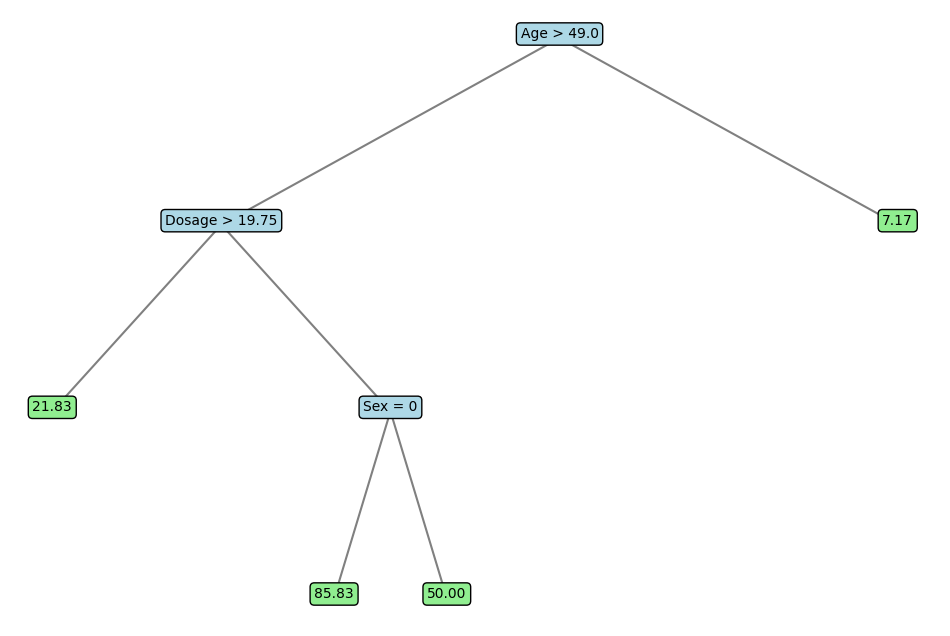

In [36]:
# Dataset
df = pd.DataFrame({
    "Dosage": [26, 41, 45, 36, 24, 35, 36, 30, 44, 11, 49, 38, 23, 39, 34, 47, 23, 13, 29, 18, 10, 26, 28, 12, 17, 17],
    "Age": [59, 19, 45, 46, 55, 51, 27, 46, 24, 59, 20, 35, 58, 23, 37, 52, 39, 48, 21, 30, 33, 47, 36, 37, 30, 47],
    "Sex": [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
    "Drug Effectiveness": [5, 50, 50, 100, 8, 9, 100, 50, 100, 4, 50, 100, 8, 50, 50, 9, 15, 15, 50, 24, 22, 100, 50, 31, 23, 16]
})

# specify the target variable and set the min_samples_split and num_thresholds parameters
min_samples_split=7
num_thresholds=3
target = "Drug Effectiveness"



X = df.drop(columns=target)
y = df[target]

# Build and plot the regression tree
regression_tree = build_regression_tree(X, y, min_samples_split, num_thresholds)
plot_regression_tree(X, regression_tree, num_thresholds=num_thresholds)